# BLIP Model Evaluation

This notebook evaluates a trained BLIP model on image-text retrieval tasks, computing Top-1/5/10 retrieval metrics on both training and validation sets. 

It includes:
- Loading a trained checkpoint
- Computing embeddings in memory-efficient chunks
- Computing similarity matrices and retrieval metrics
- Optional: visualizing example retrievals

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Optional, Tuple

from transformers import AutoProcessor, BlipForImageTextRetrieval
from PIL import Image
import json

# For mixed precision inference
from torch.cuda.amp import autocast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper class from train_blip.py
class BlipForRetrieval(BlipForImageTextRetrieval):
    def get_text_features(self,
                          input_ids: torch.LongTensor,
                          attention_mask: Optional[torch.LongTensor] = None,
                          return_dict: Optional[bool] = None,
                          ) -> torch.FloatTensor:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        question_embeds = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=return_dict,
        )
        question_embeds = question_embeds[0] if not return_dict else question_embeds.last_hidden_state

        text_feat = F.normalize(self.text_proj(question_embeds[:, 0, :]), dim=-1)

        return text_feat

    def get_image_features(
            self,
            pixel_values: torch.FloatTensor,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> torch.FloatTensor:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        image_embeds = vision_outputs[0]

        image_feat = F.normalize(self.vision_proj(image_embeds[:, 0, :]), dim=-1)

        return image_feat

In [3]:
# Dataset class from train_blip.py
def list_to_image(img_list, size=224):
    """Convert a list to a 2D image of given size."""
    return np.array(json.loads(img_list)).reshape(size, size)

class image_title_dataset():
    def __init__(self, dataframe, processor):
        self.text = dataframe["input"]
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        image = list_to_image(self.dataframe["image"][idx])
        image = Image.fromarray(image).convert("RGB") 
        image = self.processor(image)['pixel_values'][0]
        text_ = self.text[idx]
        id = self.dataframe["id"][idx]
        return image, text_, id

In [4]:
# Load model and processor
model_name = "Salesforce/blip-itm-large-coco"
processor = AutoProcessor.from_pretrained(model_name)
model = BlipForRetrieval.from_pretrained(model_name)
model.to(device)
model.eval()

# Load checkpoint
ckpt_path = "./checkpoints_blip/best_blip.pth"
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded checkpoint from epoch {ckpt['epoch']} with val_loss {ckpt['val_loss']:.4f}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded checkpoint from epoch 10 with val_loss 0.7969


In [5]:
# Load datasets
train_df = pd.read_csv("../../data/alpaca_mbj_bandgap_train.csv")
val_df = pd.read_csv("../../data/alpaca_mbj_bandgap_test.csv")

train_ds = image_title_dataset(train_df, processor)
val_ds = image_title_dataset(val_df, processor)

# Create dataloaders with a reasonable batch size for GPU memory
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
def compute_embeddings(model, dataloader, device, amp=True):
    """Compute image and text embeddings for a dataset in chunks."""
    model.eval()
    all_img_embs = []
    all_txt_embs = []
    all_ids = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Computing embeddings'):
            # Get image tensor, text list, and ids from batch
            imgs, texts, ids = batch
            imgs = imgs.to(device)
            
            # Process texts through processor
            txts = processor(text=list(texts), padding=True, return_tensors='pt').to(device)
            
            # Use AMP if requested
            if amp:
                with autocast():
                    img_feats = model.get_image_features(imgs)
                    txt_feats = model.get_text_features(input_ids=txts['input_ids'], attention_mask=txts['attention_mask'])
            else:
                img_feats = model.get_image_features(imgs)
                txt_feats = model.get_text_features(input_ids=txts['input_ids'], attention_mask=txts['attention_mask'])
            
            all_img_embs.append(img_feats.cpu())
            all_txt_embs.append(txt_feats.cpu())
            all_ids.append(ids)
    
    # Concatenate all embeddings and ids
    img_embs = torch.cat(all_img_embs)
    txt_embs = torch.cat(all_txt_embs)
    ids = torch.cat(all_ids)
    
    # Sort by ID if needed
    if ids is not None:
        sort_idx = torch.argsort(ids)
        img_embs = img_embs[sort_idx]
        txt_embs = txt_embs[sort_idx]
        ids = ids[sort_idx]
    
    return img_embs, txt_embs, ids

In [7]:
def compute_topk_chunked(img_embs, txt_embs, k=10, chunk_size=1024):
    """Compute Top-k retrieval metrics in memory-efficient chunks."""
    n = len(img_embs)
    correct_at_k = {k: 0 for k in (1, 5, 10)}
    
    # Process in chunks to avoid OOM
    for i in tqdm(range(0, n, chunk_size), desc='Computing metrics'):
        chunk_img = img_embs[i:i+chunk_size].cuda()
        chunk_txt = txt_embs[i:i+chunk_size].cuda()
        
        # Compute similarity matrix for this chunk
        sim = chunk_img @ txt_embs.cuda().t()  # chunk_size x N
        
        # For each query in chunk, get Top-k indices
        topk = torch.topk(sim, k=k, dim=1)[1]  # chunk_size x k
        
        # Count correct retrievals at different k
        for k in correct_at_k.keys():
            # For each query, is target in top-k?
            correct = torch.any(topk[:, :k] == torch.arange(i, min(i+chunk_size, n), device=topk.device).unsqueeze(1), dim=1)
            correct_at_k[k] += correct.sum().item()
        
        # Clear GPU memory
        del sim, topk
        torch.cuda.empty_cache()
    
    # Compute final metrics
    metrics = {f'top{k}': count/n for k, count in correct_at_k.items()}
    return metrics

# Compute Validation Set Metrics

Let's first evaluate on the validation set to get Top-1/5/10 retrieval metrics.

In [8]:
# Compute validation embeddings
val_img_embs, val_txt_embs, val_ids = compute_embeddings(model, val_loader, device)

# Compute validation metrics
print("Computing validation metrics...")
val_metrics = compute_topk_chunked(val_img_embs, val_txt_embs)
print("\nValidation Metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

Computing embeddings:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_264342/1908032202.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Computing embeddings: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Computing validation metrics...


Computing metrics: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Validation Metrics:
top1: 0.1730
top5: 0.4290
top10: 0.5520


# Compute Training Set Metrics

Now let's compute the same metrics on the training set to check for overfitting.

In [9]:
# Compute training embeddings
train_img_embs, train_txt_embs, train_ids = compute_embeddings(model, train_loader, device)

# Compute training metrics
print("Computing training metrics...")
train_metrics = compute_topk_chunked(train_img_embs, train_txt_embs)
print("\nTraining Metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

Computing embeddings:   0%|          | 0/157 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKEN

Computing training metrics...


Computing metrics: 100%|██████████| 5/5 [00:00<00:00, 79.71it/s]


Training Metrics:
top1: 0.3868
top5: 0.7564
top10: 0.8728


# Example Retrievals

Let's look at some example retrievals from the validation set to qualitatively assess the model.

In [10]:
def show_retrievals(query_idx, img_embs, txt_embs, texts, k=5):
    """Show top-k retrievals for a query image or text."""
    with torch.no_grad():
        # Get query embeddings
        q_img = img_embs[query_idx].cuda()
        q_txt = txt_embs[query_idx].cuda()
        
        # Compute similarities
        img2txt = q_img @ txt_embs.cuda().t()
        txt2img = q_txt @ img_embs.cuda().t()
        
        # Get top-k indices
        _, i2t_idx = torch.topk(img2txt, k)
        _, t2i_idx = torch.topk(txt2img, k)
        
        print(f"Query text: {texts[query_idx]}\n")
        print("Top image→text retrievals:")
        for i, idx in enumerate(i2t_idx.cpu().numpy(), 1):
            print(f"{i}. {texts[idx]}")
        
        print("\nTop text→image retrievals:")
        for i, idx in enumerate(t2i_idx.cpu().numpy(), 1):
            print(f"{i}. {texts[idx]}")

# Show retrievals for a few random validation examples
for idx in np.random.choice(len(val_ds), 3):
    print(f"\nExample {idx}")
    print("=" * 80)
    show_retrievals(idx, val_img_embs, val_txt_embs, val_df['input'].values)


Example 820
Query text: The chemical formula is GaRh. The  mbj_bandgap value is 0.0.

Top image→text retrievals:
1. The chemical formula is GaCo2Ni. The  mbj_bandgap value is 0.0.
2. The chemical formula is SrCd2Ga2. The  mbj_bandgap value is 0.0.
3. The chemical formula is ZnCuAu2. The  mbj_bandgap value is 0.0.
4. The chemical formula is GaRh. The  mbj_bandgap value is 0.0.
5. The chemical formula is Be2ZnRh. The  mbj_bandgap value is 0.0.

Top text→image retrievals:
1. The chemical formula is MnAlRh2. The  mbj_bandgap value is 0.0.
2. The chemical formula is ZrTe. The  mbj_bandgap value is 0.0.
3. The chemical formula is GaRh. The  mbj_bandgap value is 0.0.
4. The chemical formula is InCu. The  mbj_bandgap value is 0.0.
5. The chemical formula is GaSe. The  mbj_bandgap value is 2.071.

Example 859
Query text: The chemical formula is Sc2Sb. The  mbj_bandgap value is 0.0.

Top image→text retrievals:
1. The chemical formula is MnSb. The  mbj_bandgap value is 0.0.
2. The chemical formu

# Embedding Visualization

Let's visualize how well our model aligns the image and text embeddings in the shared space using t-SNE dimensionality reduction.

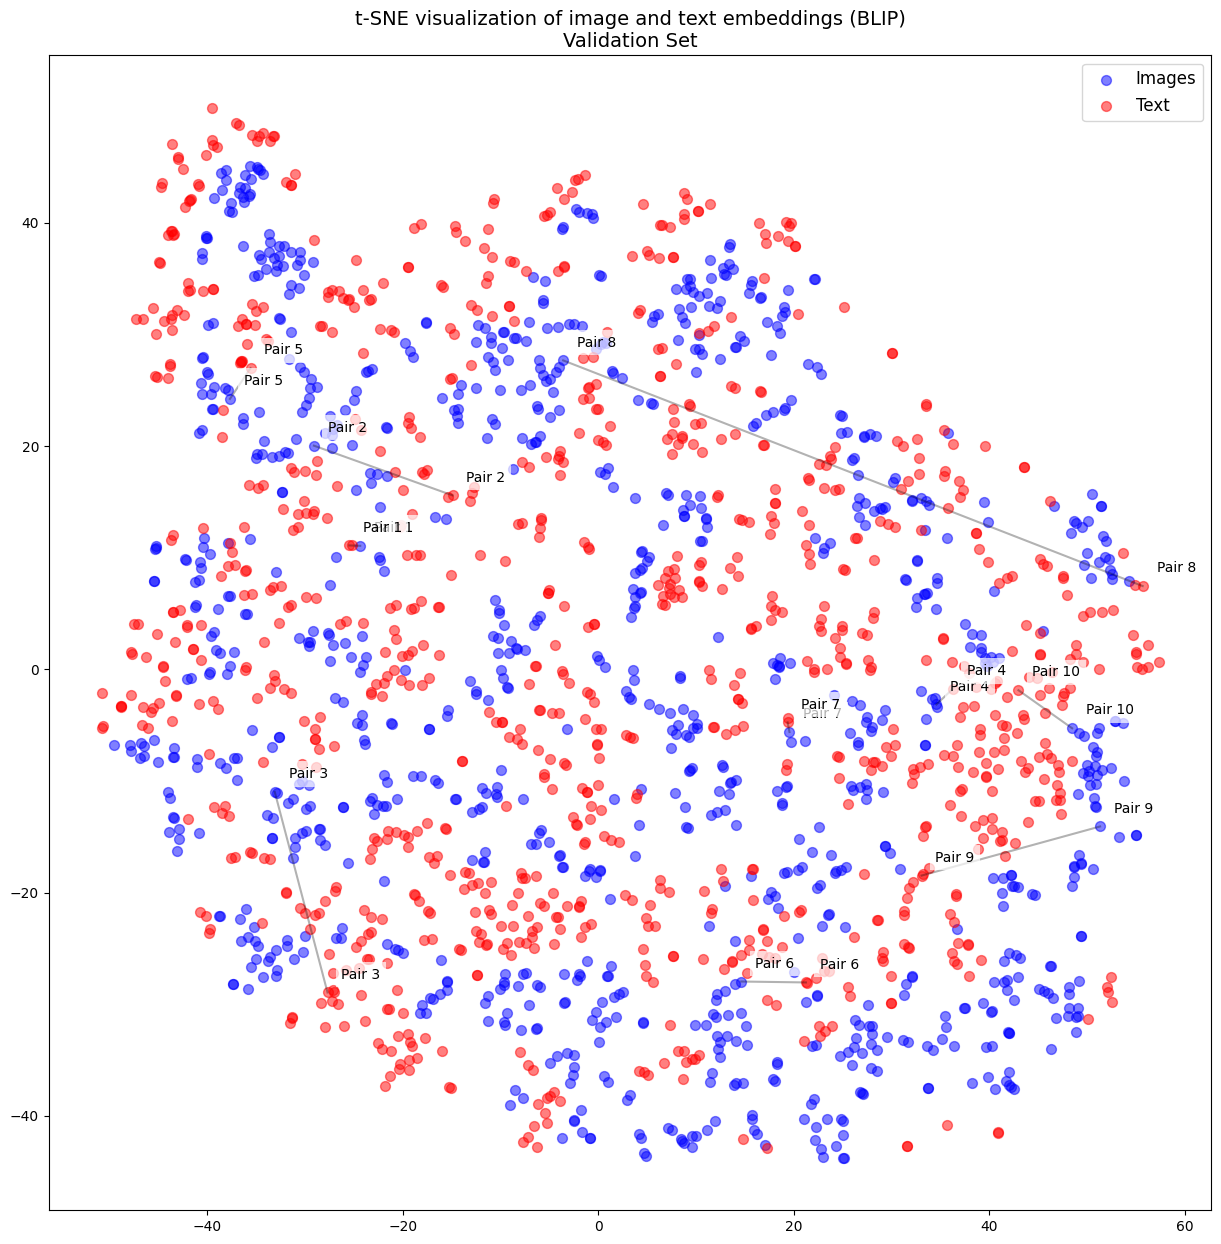

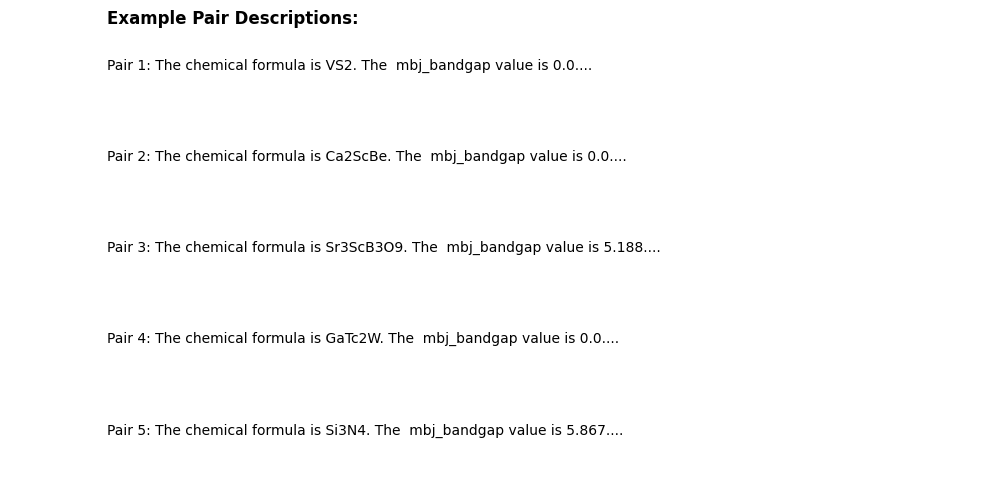

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Only use validation embeddings for visualization
combined_embs = torch.cat([val_img_embs, val_txt_embs], dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
combined_tsne = tsne.fit_transform(combined_embs.numpy())

# Split back into image and text embeddings
n = len(val_img_embs)
img_tsne = combined_tsne[:n]
txt_tsne = combined_tsne[n:]

# Create visualization
plt.figure(figsize=(15, 15))

# Plot all points
plt.scatter(img_tsne[:, 0], img_tsne[:, 1], c='blue', label='Images', alpha=0.5, s=50)
plt.scatter(txt_tsne[:, 0], txt_tsne[:, 1], c='red', label='Text', alpha=0.5, s=50)

# Draw lines connecting corresponding pairs for a subset of examples
num_examples = 10  # Number of example pairs to highlight
random_indices = np.random.choice(n, num_examples, replace=False)

for i, idx in enumerate(random_indices):
    # Draw a line connecting the image-text pair
    plt.plot([img_tsne[idx, 0], txt_tsne[idx, 0]], 
             [img_tsne[idx, 1], txt_tsne[idx, 1]], 
             'k-', alpha=0.3)
    
    # Add number labels
    plt.annotate(f'Pair {i+1}', 
                xy=(img_tsne[idx, 0], img_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'Pair {i+1}', 
                xy=(txt_tsne[idx, 0], txt_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(fontsize=12)
plt.title('t-SNE visualization of image and text embeddings (BLIP)\nValidation Set', fontsize=14)

# Add text descriptions for a few example pairs
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.text(0.1, 1.0, 'Example Pair Descriptions:', fontsize=12, fontweight='bold')
for i, idx in enumerate(random_indices[:5]):  # Show first 5 pairs
    plt.text(0.1, 0.9 - i*0.2, f'Pair {i+1}: {val_df["input"].values[idx][:100]}...', 
             fontsize=10, wrap=True)

plt.tight_layout()
plt.show()